me base en esta fuente de la pagina de pennyland
- https://pennylane.ai/qml/demos/tutorial_qaoa_intro/

Tambien asumi que la funcción que describe el Coste del Hamiltoniano es **min_vertex_cover**. Que segun la pagina de pennyland: https://docs.pennylane.ai/en/stable/code/qml_qaoa.html

Returns the QAOA cost Hamiltonian and the recommended mixer corresponding to the Minimum Vertex Cover problem, for a given graph.



In [1]:
import pennylane as qml
from pennylane import qaoa
from pennylane import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

In [2]:
def mapFriendships(friendships):
  '''
  Este metodo mapea la relacion de amistad de las personas y devuelve un mapa y la relacion en con el formato [(0,1), (1,2), ...]
  '''
  name_to_index = {}
  current_index = 0

  for friendship in friendships:
      for name in friendship:
          if name not in name_to_index:
              name_to_index[name] = current_index
              current_index += 1

  indexed_friendships = [(name_to_index[friendship[0]], name_to_index[friendship[1]]) for friendship in friendships]

  return name_to_index, indexed_friendships

In [3]:
def create_graph_from_friendships(friendships):
    """Create a NetworkX graph from a list of friendships."""
    g = nx.Graph()
    g.add_edges_from(friendships)
    return g

In [4]:
# Relacion inicial de amistades
init_friendships = [
  ["Mario", "Sarah"],
  ["Mario", "Raul"],
  ["Mario", "Ana"],
  ["Enrique", "Sarah"],
  ["Enrique", "Raul"],
  ["Saul", "Ana"],
]

map_friendships, friendships = mapFriendships(init_friendships)

g = create_graph_from_friendships(friendships)
dev = qml.device('default.qubit', wires=len(g.nodes))

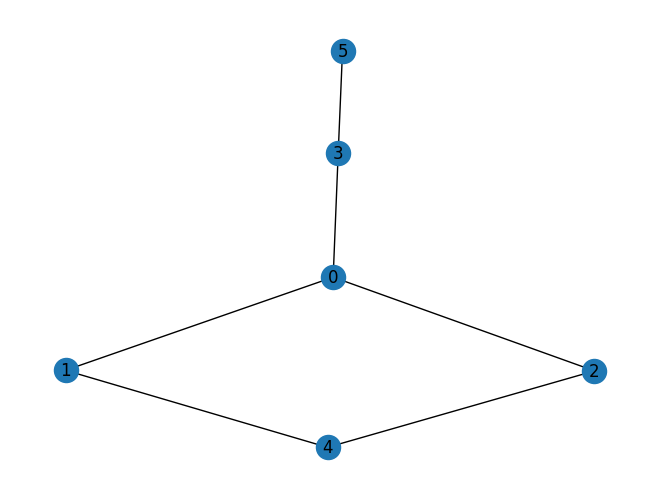

In [5]:
nx.draw(g, with_labels=True)
plt.show()

In [6]:
cost_h, mixer_h = qaoa.min_vertex_cover(g, constrained=False)

In [7]:
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

In [8]:
wires = range(len(map_friendships.items()))
# 2 niveles de profundidad como plantea el enunciado del problema
depth = 3

def circuit(params, **kwargs):
    for w in wires:
        qml.Hadamard(wires=w)
    qml.layer(qaoa_layer, depth, params[0], params[1])

In [9]:
@qml.qnode(dev)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

In [10]:
optimizer = qml.GradientDescentOptimizer()
steps = 70
params = np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]], requires_grad=True)

In [11]:
# Representacion del circuito
print(qml.draw(cost_function, expansion_strategy='device')(params = params))

0: ──H─╭RZZ(0.75)──RZ(1.25)─╭RZZ(0.75)───────────╭RZZ(0.75)──RX(1.00)─────────────────────
1: ──H─╰RZZ(0.75)──RZ(0.50)─│────────────────────│────────────────────╭RZZ(0.75)──RX(1.00)
2: ──H──────────────────────╰RZZ(0.75)──RZ(0.50)─│────────────────────│───────────────────
3: ──H───────────────────────────────────────────╰RZZ(0.75)──RZ(0.50)─│───────────────────
4: ──H────────────────────────────────────────────────────────────────╰RZZ(0.75)──RZ(0.50)
5: ──H────────────────────────────────────────────────────────────────────────────────────

──╭RZZ(0.75)──RZ(1.25)──╭RZZ(0.75)───────────╭RZZ(0.75)──RX(1.00)──────────────────────╭RZZ(0.75)
──╰RZZ(0.75)──RZ(0.50)──│────────────────────│────────────────────╭RZZ(0.75)──RX(1.00)─╰RZZ(0.75)
──╭RZZ(0.75)──RX(1.00)──╰RZZ(0.75)──RZ(0.50)─│────────────────────│────────────────────╭RZZ(0.75)
──│──────────╭RZZ(0.75)──RX(1.00)────────────╰RZZ(0.75)──RZ(0.50)─│────────────────────│─────────
──╰RZZ(0.75)─│───────────RX(1.00)────────────────────────────

In [12]:
# Defincicion de los parametros optimos
for i in range(steps):
    params = optimizer.step(cost_function, params)

print("Optimal Parameters")
print(params)

Optimal Parameters
[[0.54746346 0.4923788  0.86671131]
 [0.58571054 0.49269125 1.01184449]]


In [13]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)


probs = probability_circuit(params[0], params[1])

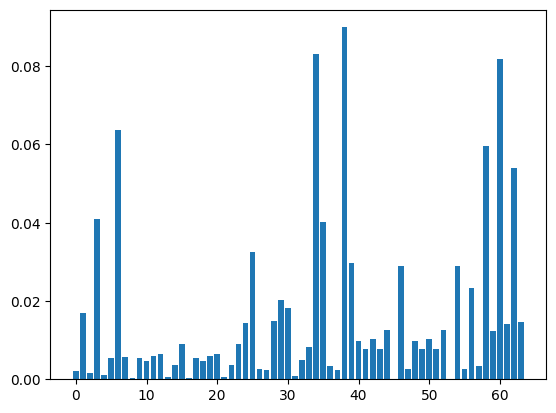

In [14]:
plt.bar(range(2 ** len(wires)), probs)
plt.show()

In [15]:
# probs.argmax(): obtiene el indice con el valor mas alto
# binario: La representacion binaria de indice de mayou probabilidad
binario = bin(probs.argmax())[2:]
probs.max(), probs.argmax(), binario

(tensor(0.08992792, requires_grad=True), 38, '100110')

In [16]:
names = []
for i, bit in enumerate(binario):
    if bit == '1':
        for name, idx in map_friendships.items():
            if idx == i:
                names.append(name)
names

['Mario', 'Ana', 'Enrique']

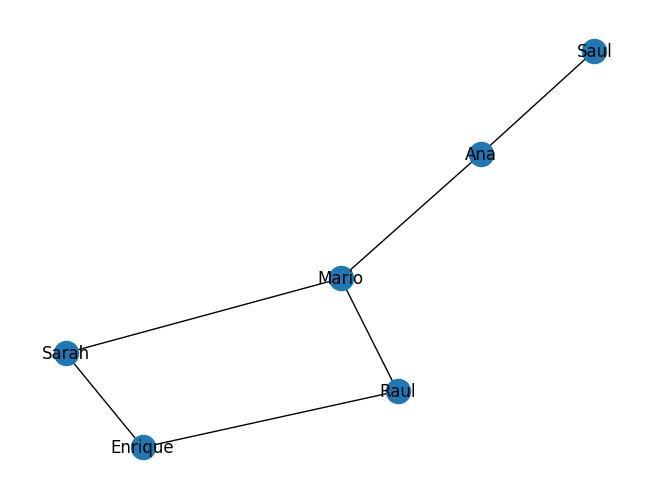

In [17]:
info_g = create_graph_from_friendships(init_friendships)
nx.draw(info_g, with_labels=True)
plt.show()